New train function that uses whole training data without validation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.utils import shuffle
import glob
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from model_files import model1

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)


Read numpy files

In [3]:
# Get the paths where all the files are stored
current_path = os.getcwd()
data_path = current_path + '/Data'

In [4]:
# Load all train data and test data
xtr = np.load(data_path+'/xtrain.npy')
ytr = np.load(data_path+'/ytrain.npy')
xtst = np.load(data_path+'/xtest.npy')

In [5]:
# Convert labels to categorical columns
ytrain = tf.keras.utils.to_categorical(ytr, len(np.unique(ytr)))
# Expand dims for the training and validation data
xtrain = np.expand_dims(xtr,axis=-1)
xtest = np.expand_dims(xtst,axis=-1)

In [6]:
print('shape of whole train datasets',np.shape(xtrain))
print('shape of train label datasets',np.shape(ytrain))
print('shape of whole test datasets',np.shape(xtest))

shape of whole train datasets (42000, 28, 28, 1)
shape of train label datasets (42000, 10)
shape of whole test datasets (28000, 28, 28, 1)


In [7]:
xval = []
ylabel_val = []

Perform model training

In [8]:
# Parameters and hyperparameters of the model

## 99.68 accuracy with current model
'''
output_shape = len(np.unique(ytrain))
input_shape = np.shape(xtrain[0,:,:,:])
kernel_list = [[32, (3,3), (1,1)],
              [32, (3,3), (1,1)],
              [32, (3,3), (1,1)],
               [64, (3,3), (1,1)],
               [64, (3,3), (2,2)]]
learn_rate = 5*10**-4
num_iterr = 30
batch_size = 32
'''

output_shape = len(np.unique(ytr))
input_shape = np.shape(xtrain[0,:,:,:])
kernel_list = [[32, (3,3), (1,1)],
              [32, (3,3), (2,2)],
              [32, (3,3), (1,1)],
               [64, (3,3), (1,1)],
               [64, (3,3), (1,1)]]
learn_rate = 5*10**-4
num_iterr = 100
batch_size = 32

In [9]:
def train_model(xtrain, ytrain, xval, ylabel_val, input_shape, kernel_list, learn_rate, output_shape, num_iterr, batch_size=32):
    """
    Function to train model
    
    Input Args:
    xtrain: Input images in numpy format
    ytrain: Input image labels
    xval: Validation images as numpy format
    ylabel_val: Validation image labels
    input_shape: Shape of the input image provided. The input shape should be 28x28x1
    kernel_list: List of kernel level information. Its a list of list containing per 
                    level number of kernels and the kernel shape of the model.
    learn_rate: Learning rate of the optimizer
    output_shape: Shape of the final layer of the model. 10 in our case
    num_iterr: Number of epochs for training
    batch_size: Number of batches of images per epoch
    
    Output Args:
    models: Weights of the model at each step
    loss_list: List of training loss
    accuracy_list: List of training accuracy 
    val_loss_list: List of validation loss
    val_acc_list: List of validation accuracy
    """
    val_loss_list = []
    val_acc_list = []
    loss_list = []
    accuracy_list = []
    model_wt_dict = {}
    # Initialize the model
    model = model1(input_shape, 
                        kernel_list, 
                        learn_rate, 
                        output_shape)
    # Train the model
    for i in range(num_iterr):
        print('Epoch number:{0}/{1}'.format(i+1, num_iterr))
        # Check validation set is provided
        if not xval or not ylabel_val:
            history = model.fit(xtrain, 
                            ytrain, 
                            epochs=1,
                            batch_size = batch_size)
            val_loss, val_acc = model.evaluate(xtrain,  
                                               ytrain, 
                                               verbose=2)
        else:
            history = model.fit(xtrain, 
                                ytrain, 
                                epochs=1, 
                                validation_data=(xval, ylabel_val),
                                batch_size = batch_size)
            # get the validation loss and accuracy and store it
            val_loss = history.history['val_loss']
            val_acc = history.history['val_accuracy']
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        # get the training loss and accuracy and store it
        train_loss = history.history['loss']
        train_acc = history.history['accuracy']
        loss_list.append(train_loss)
        accuracy_list.append(train_acc)
        # Store the model weights, and history
        model_weights = model.get_weights() 
        model_wt_dict[i] = model_weights
    return model_wt_dict, loss_list, accuracy_list, val_loss_list, val_acc_list

In [10]:
model_wt_dict, loss_list, accuracy_list, val_loss_list, val_acc_list = train_model(xtrain, 
                                                                            ytrain,
                                                                            xval,  
                                                                            ylabel_val, 
                                                                            input_shape, 
                                                                            kernel_list, 
                                                                            learn_rate, 
                                                                            output_shape,
                                                                            num_iterr,
                                                                            batch_size)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
batchnorm1 (BatchNormalizati (None, 26, 26, 32)        128       
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 26, 26, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 12, 12, 32)        9248      
_________________________________________________________________
batchnorm2 (BatchNormalizati (None, 12, 12, 32)        128       
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 12, 12, 32)        0     

Epoch number:29/100
Train on 42000 samples
42000/42000 [==============================] - 8s 181us/sample - loss: 0.0068 - accuracy: 0.9980
42000/42000 - 4s - loss: 0.0044 - accuracy: 0.9982
Epoch number:30/100
Train on 42000 samples
42000/42000 [==============================] - 8s 182us/sample - loss: 0.0074 - accuracy: 0.9975
42000/42000 - 4s - loss: 0.0036 - accuracy: 0.9987
Epoch number:31/100
Train on 42000 samples
42000/42000 [==============================] - 8s 181us/sample - loss: 0.0075 - accuracy: 0.9979
42000/42000 - 3s - loss: 0.0051 - accuracy: 0.9984
Epoch number:32/100
Train on 42000 samples
42000/42000 [==============================] - 8s 181us/sample - loss: 0.0050 - accuracy: 0.9985
42000/42000 - 4s - loss: 0.0060 - accuracy: 0.9979
Epoch number:33/100
Train on 42000 samples
42000/42000 [==============================] - 8s 180us/sample - loss: 0.0067 - accuracy: 0.9980
42000/42000 - 4s - loss: 0.0114 - accuracy: 0.9965
Epoch number:34/100
Train on 42000 samples
42

Epoch number:72/100
Train on 42000 samples
42000/42000 [==============================] - 9s 203us/sample - loss: 0.0020 - accuracy: 0.9995
42000/42000 - 4s - loss: 0.0010 - accuracy: 0.9996
Epoch number:73/100
Train on 42000 samples
42000/42000 [==============================] - 8s 183us/sample - loss: 0.0038 - accuracy: 0.9990
42000/42000 - 3s - loss: 0.0015 - accuracy: 0.9995
Epoch number:74/100
Train on 42000 samples
42000/42000 [==============================] - 8s 188us/sample - loss: 0.0019 - accuracy: 0.9993
42000/42000 - 4s - loss: 0.0035 - accuracy: 0.9992
Epoch number:75/100
Train on 42000 samples
42000/42000 [==============================] - 8s 194us/sample - loss: 0.0036 - accuracy: 0.9991
42000/42000 - 4s - loss: 0.0010 - accuracy: 0.9995
Epoch number:76/100
Train on 42000 samples
42000/42000 [==============================] - 9s 203us/sample - loss: 0.0030 - accuracy: 0.9990
42000/42000 - 4s - loss: 6.1068e-04 - accuracy: 0.9998
Epoch number:77/100
Train on 42000 sample

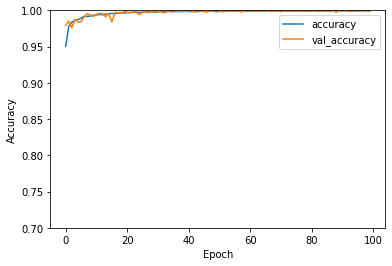

In [11]:
plt.plot(accuracy_list, label='accuracy')
plt.plot(val_acc_list, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1])
plt.legend(loc='best')
plt.show()

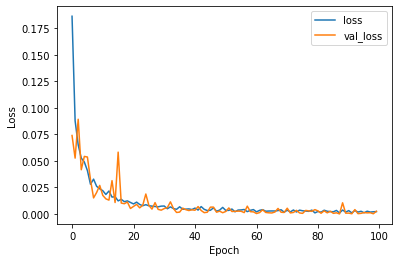

In [12]:
plt.plot(loss_list, label='loss')
plt.plot(val_loss_list, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [13]:
# Find model with the least validation loss
index = np.argmin(val_loss_list)
print(np.amin(val_loss_list))
# Use that index to retrieve model weights
model_wt = model_wt_dict[index]
print('Best model is at {0}th epoch'.format(index))

8.919358073094602e-05
Best model is at 87th epoch


In [14]:
# Load the model with weights
model = model1(input_shape, 
                        kernel_list, 
                        learn_rate, 
                        output_shape)
model.set_weights(model_wt)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
batchnorm1 (BatchNormalizati (None, 26, 26, 32)        128       
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 26, 26, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 12, 12, 32)        9248      
_________________________________________________________________
batchnorm2 (BatchNormalizati (None, 12, 12, 32)        128       
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 12, 12, 32)        0   

Evaluate the model

In [15]:
# Test accuracy on the entire dataset
train_wh_loss, train_wh_accuracy = model.evaluate(xtrain,  ytrain, verbose=2)

print('\nTrain accuracy on whole dataset = {0:.2f}%'.format(train_wh_accuracy*100.0))

42000/42000 - 9s - loss: 8.9194e-05 - accuracy: 1.0000

Train accuracy on whole dataset = 100.00%


Save the model

In [16]:
# Check if save path exists, if not then create one
save_path = current_path + '/model' 
if not os.path.isdir(save_path):
    os.makedirs(save_path)

In [17]:
def create_submission(model, xtest, current_path):
    """
    Create keggale submission csv. This also performs prediction on xtest
    
    Input Args:
    model: Trained model
    xtest: Numpy image of the test dataset
    current_path: Path where submission file has to be created.
                    It takes the previously stored sample submission file which you get 
                    from kaggle dataset
    """
    # Predict test set labels
    ypred = model.predict(xtest)
    # Get labels for each row with maximum column value
    ytest_label = np.argmax(ypred, axis=1)
    # read the sample submission file 
    samp_submission_df = pd.read_csv(current_path+'/sample_submission.csv')
    # add the the new ytest label 
    samp_submission_df.loc[:,'Label'] = ytest_label
    # Save the file as submission 
    samp_submission_df.to_csv(current_path + '/submission.csv', index=False)

In [18]:
# Save model if the accuracy on whole dataset is greater than 99.9 and also create test submission
if round(train_wh_accuracy*100.0,3) > 99.9:
    filename = save_path + '/model' + str(round(train_wh_accuracy*100.0,3))
    model_json = model.to_json()
    with open(filename + '.json', "w") as json_file:
        json_file.write(model_json)

    # Save weights of the model
    model.save_weights(filename+'.h5')
    # Create submission
    create_submission(model, xtest, current_path)
    